# Perform time series forecasting using XGBoost

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from joblib import dump
from joblib import load

In [36]:
df = pd.read_csv("./data/Mastercard_stock_history.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000,0.0,0.0
1,2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000,0.0,0.0
2,2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000,0.0,0.0
3,2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000,0.0,0.0
4,2006-06-01,4.179678,4.474572,4.176887,4.419686,62344000,0.0,0.0


Once again, we try to forecast the close price using previous date features, as well as generating new features for our model to predict the close price

In [37]:
# convert Date into datetime, and set the date as the index of the dataframe
df['Date'] = pd.to_datetime(df['Date'])
# set date as the index
df.set_index('Date', inplace=True)

df = df.asfreq("D")
df = df.interpolate() # interpolate data to remove NaN values

## Create new features for the model

We will create features for:

1. month
2. day of the week
3. moving average
4. moving standard deviation
5. previous days' lagged close prices
6. open price
7. quarter of the year

In [38]:
df['month'] = df.index.month
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,month
Date,,,,,,,,
2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000.0,0.0,0.0,5
2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000.0,0.0,0.0,5
2006-05-27,4.276195,4.307126,4.074094,4.158051,89757500.0,0.0,0.0,5
2006-05-28,4.245263,4.266194,4.044791,4.136422,76471000.0,0.0,0.0,5
2006-05-29,4.214332,4.225262,4.015487,4.114793,63184500.0,0.0,0.0,5


In [39]:
df['day'] = df.index.day_of_week
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,month,day
Date,,,,,,,,,
2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000.0,0.0,0.0,5,3
2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000.0,0.0,0.0,5,4
2006-05-27,4.276195,4.307126,4.074094,4.158051,89757500.0,0.0,0.0,5,5
2006-05-28,4.245263,4.266194,4.044791,4.136422,76471000.0,0.0,0.0,5,6
2006-05-29,4.214332,4.225262,4.015487,4.114793,63184500.0,0.0,0.0,5,0


In [40]:
df['quarter'] = df.index.quarter
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,month,day,quarter
Date,,,,,,,,,,
2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000.0,0.0,0.0,5,3,2
2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000.0,0.0,0.0,5,4,2
2006-05-27,4.276195,4.307126,4.074094,4.158051,89757500.0,0.0,0.0,5,5,2
2006-05-28,4.245263,4.266194,4.044791,4.136422,76471000.0,0.0,0.0,5,6,2
2006-05-29,4.214332,4.225262,4.015487,4.114793,63184500.0,0.0,0.0,5,0,2


In [41]:
df['lag_1'] = df['Close'].shift(1)
df['lag_2'] = df['Close'].shift(2)

df = df.dropna()
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,month,day,quarter,lag_1,lag_2
Date,,,,,,,,,,,,
2006-05-27,4.276195,4.307126,4.074094,4.158051,89757500.0,0.0,0.0,5,5,2,4.179680,4.279217
2006-05-28,4.245263,4.266194,4.044791,4.136422,76471000.0,0.0,0.0,5,6,2,4.158051,4.179680
2006-05-29,4.214332,4.225262,4.015487,4.114793,63184500.0,0.0,0.0,5,0,2,4.136422,4.158051
2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000.0,0.0,0.0,5,1,2,4.114793,4.136422
2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000.0,0.0,0.0,5,2,2,4.093164,4.114793


In [42]:
df['MA'] = df["Close"].rolling(30).mean()
df['M_STD'] = df["Close"].rolling(30).std()

df = df.dropna() # remove NaNs after rolling functions have been applied

In [46]:
columns_to_keep = ["Open", "Volume", "Close", "month", "day", "quarter", "lag_1", "lag_2", "MA", "M_STD"]
df1 = df[columns_to_keep]
df1.head()

,Open,Volume,Close,month,day,quarter,lag_1,lag_2,MA,M_STD
Date,,,,,,,,,,
2006-06-25,4.368834,9.580667e+06,4.401703,6,6,2,4.384648,4.367593,4.303451,0.142308
2006-06-26,4.367594,8.565000e+06,4.418758,6,0,2,4.401703,4.384648,4.312141,0.141078
2006-06-27,4.418758,9.826000e+06,4.401083,6,1,2,4.418758,4.401703,4.320963,0.137951
2006-06-28,4.358291,8.756000e+06,4.368524,6,2,2,4.401083,4.418758,4.329421,0.132547
2006-06-29,4.367592,1.447000e+07,4.465270,6,3,2,4.368524,4.401083,4.341824,0.126970


## Standardize the data

In [47]:
scaler = StandardScaler()
cols_to_standardize = ['Open', "Volume", "lag_1", "lag_2", "MA", "M_STD"]
df1[cols_to_standardize] = scaler.fit_transform(df1[cols_to_standardize])
df1.head()

C:\Users\yjiah\AppData\Local\Temp\ipykernel_2940\1057776981.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[cols_to_standardize] = scaler.fit_transform(df1[cols_to_standardize])


,Open,Volume,Close,month,day,quarter,lag_1,lag_2,MA,M_STD
Date,,,,,,,,,,
2006-06-25,-0.951307,-0.146871,4.401703,6,6,2,-0.951416,-0.951369,-0.950295,-0.685949
2006-06-26,-0.951318,-0.211281,4.418758,6,0,2,-0.951255,-0.951208,-0.950213,-0.686279
2006-06-27,-0.950837,-0.131313,4.401083,6,1,2,-0.951095,-0.951047,-0.950129,-0.687119
2006-06-28,-0.951406,-0.199168,4.368524,6,2,2,-0.951261,-0.950887,-0.950049,-0.688571
2006-06-29,-0.951318,0.163191,4.465270,6,3,2,-0.951568,-0.951053,-0.949931,-0.690069


## Modelling

In [66]:
# split data into last 20 days to predict as test data
df_train = df1.iloc[:-100]
df_test = df1.iloc[-100:]

X_train = df_train[["Open", "Volume", "month", "day", "quarter", "lag_1", "lag_2", "MA", "M_STD"]]
y_train = df_train[["Close"]]
X_test = df_test[["Open", "Volume", "month", "day", "quarter", "lag_1", "lag_2", "MA", "M_STD"]]
y_test = df_test[["Close"]]

In [67]:
model = XGBRegressor(objective = "reg:squarederror")
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [68]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Root mean squared error is: {np.sqrt(mse) : .2f}")

Root mean squared error is:  5.93


In [69]:
y_pred

array([374.76776, 374.70016, 374.3668 , 375.0045 , 369.45984, 371.66162,
       370.6869 , 370.95227, 377.42014, 373.02887, 379.93982, 380.35992,
       381.25443, 381.04358, 375.9929 , 371.89062, 367.7599 , 373.33966,
       378.69965, 380.36145, 378.40332, 377.9388 , 378.3886 , 379.06482,
       376.75015, 382.82147, 378.8174 , 377.61194, 377.85022, 378.57025,
       380.3754 , 366.0384 , 366.2077 , 366.6116 , 371.8663 , 366.59567,
       367.96844, 365.39127, 365.78674, 368.5436 , 365.16794, 363.58716,
       363.17365, 360.55923, 363.49292, 363.09247, 361.90158, 359.7179 ,
       356.6025 , 360.39825, 360.6748 , 362.31482, 364.45615, 357.17953,
       358.5118 , 361.6226 , 357.08057, 356.0125 , 359.83157, 344.07428,
       354.70767, 338.04407, 339.5774 , 343.76294, 342.83554, 343.42456,
       343.07324, 353.8261 , 352.32855, 342.37344, 342.33554, 343.836  ,
       343.92523, 346.20056, 345.0254 , 343.97882, 343.93265, 340.61682,
       338.49802, 338.69983, 340.5908 , 345.98547, 

Plot the predicted and actual data

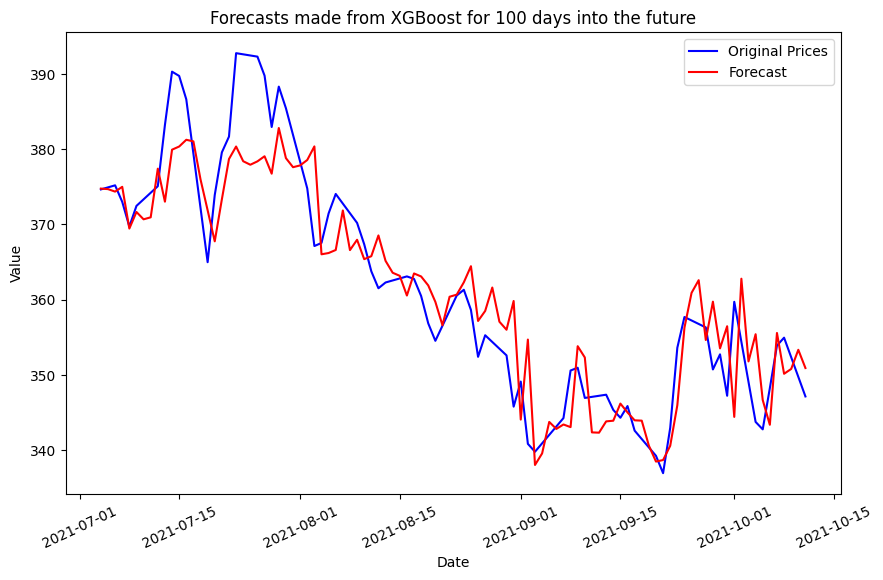

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(X_test.index, y_test, label = "Original Prices", color = "blue")
plt.plot(X_test.index, y_pred, label = "Forecast", color = "red")

# Add labels and title
plt.title("Forecasts made from XGBoost for 100 days into the future")
plt.xlabel("Date")
plt.ylabel("Value")
plt.xticks(rotation = 25)
plt.legend()

# Show the plot
plt.show()

We can see that the XGBoost model is much better at predicting the time series compared to ARIMA in the modelling notebook, as we get a much lower MSE

## Save the model

In [74]:
dump(model, "./models/XGBRegressor.pkl")

['./models/XGBRegressor.pkl']

In [76]:
# test loading of model
test_model = load("./models/XGBRegressor.pkl")

In [77]:
test_model.predict(X_test)

array([374.76776, 374.70016, 374.3668 , 375.0045 , 369.45984, 371.66162,
       370.6869 , 370.95227, 377.42014, 373.02887, 379.93982, 380.35992,
       381.25443, 381.04358, 375.9929 , 371.89062, 367.7599 , 373.33966,
       378.69965, 380.36145, 378.40332, 377.9388 , 378.3886 , 379.06482,
       376.75015, 382.82147, 378.8174 , 377.61194, 377.85022, 378.57025,
       380.3754 , 366.0384 , 366.2077 , 366.6116 , 371.8663 , 366.59567,
       367.96844, 365.39127, 365.78674, 368.5436 , 365.16794, 363.58716,
       363.17365, 360.55923, 363.49292, 363.09247, 361.90158, 359.7179 ,
       356.6025 , 360.39825, 360.6748 , 362.31482, 364.45615, 357.17953,
       358.5118 , 361.6226 , 357.08057, 356.0125 , 359.83157, 344.07428,
       354.70767, 338.04407, 339.5774 , 343.76294, 342.83554, 343.42456,
       343.07324, 353.8261 , 352.32855, 342.37344, 342.33554, 343.836  ,
       343.92523, 346.20056, 345.0254 , 343.97882, 343.93265, 340.61682,
       338.49802, 338.69983, 340.5908 , 345.98547, 

Our model can be saved and loaded successfully.